# Data Preparation - 1-Second Resolution (1sec_new)

Preprocessing pipeline for NILM data at **1-second resolution** from `1sec_new` folder.

## Dataset Overview
| Aspect | Value |
|--------|-------|
| Resolution | 1 second (native) |
| Valid periods | July 2024 - September 2025 |
| Total days | ~448 |
| Estimated rows | ~38M |
| Appliances | 11 monitored devices |

## ⚠️ Resolution Note
Raw file analysis revealed different resolutions:
- **March 2024**: 1 second (sparse, gaps)
- **April-May 2024**: 10 seconds ❌
- **July 2024+**: 1 second ✅

Only July 2024+ data is used to ensure true 1-second resolution.

## Output
All files saved to `data/processed/1sec_new/`:
- `nilm_ready_1sec_new.parquet` — Complete dataset
- `dataset_metadata_1sec_new.json` — Metadata
- `splits/` — Train/Val/Test CSV (block-interleaved)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

# Paths - OUTPUT IS 1sec (NO resampling!)
BASE_DIR = Path('.').resolve().parent.parent
RAW_DIR = BASE_DIR / 'data' / 'raw' / '1sec_new'
OUTPUT_DIR = BASE_DIR / 'data' / 'processed' / '1sec_new'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f'Base directory: {BASE_DIR}')
print(f'Raw data: {RAW_DIR}')
print(f'Output: {OUTPUT_DIR}')
print(f'\nFiles available:')
for f in sorted(RAW_DIR.glob('*.csv')):
    print(f'   {f.name}')

Base directory: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1
Raw data: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\raw\1sec_new
Output: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\1sec_new

Files available:
   household_2024_03.csv
   household_2024_04.csv
   household_2024_05.csv
   household_2024_07.csv
   household_2024_08.csv
   household_2024_09.csv
   household_2024_10.csv
   household_2024_11.csv
   household_2024_12.csv
   household_2025_01.csv
   household_2025_02.csv
   household_2025_03.csv
   household_2025_04.csv
   household_2025_05.csv
   household_2025_06.csv
   household_2025_07.csv
   household_2025_08.csv
   household_2025_09.csv
   household_2025_10.csv
   household_2025_11.csv
   household_2025_12.csv


---
## 1. Column Configuration & Corrections

Target column definitions and preprocessing strategy:

| Correction | Reason |
|------------|--------|
| `clip(lower=0)` | Removes negative sensor offsets when appliances are OFF |
| Noise threshold 5W | Values below 5W are measurement noise |
| Double counting fix | `GarageCabinet` includes `HeatPump`, `EVCharger`, and `EVSocket` as sub-meters |

### Circuit Topology (Verified via data analysis)
```
GarageCabinet CT clamp measures total of:
├── HeatPump (sub-meter) → SUBTRACTED
├── EVCharger (sub-meter) → SUBTRACTED
├── EVSocket (sub-meter) → SUBTRACTED
└── Actual garage loads (~60W residual)
```

**Verification**: R² = 0.998, Correlation = 0.999, GC ≥ HP+EV in 100% of samples.

**Note**: Solar, Grid, Battery columns are **NOT** included in the NILM dataset.  
They are energy flow meters (bidirectional), not consumption appliances.

In [2]:
# Column mapping: raw names → standardized names
TARGET_COLUMNS = {
    'time': 'Time',
    
    # Aggregate (building main meter)
    'building_33a8340b-f03c-4851-9f9f-99b98e2c4cc9': 'Aggregate',
    'building_33a8340b-f03c-4851-9f9f-99b98e2c4cc12': 'Aggregate',
    
    # Appliances
    'heat_pump': 'HeatPump',
    'dishwasher': 'Dishwasher',
    'washing_machine': 'WashingMachine',
    'dryer': 'Dryer',
    'oven': 'Oven',
    'stove': 'Stove',
    'range_hood': 'RangeHood',
    'ev_charger': 'EVCharger',
    'ev_socket': 'EVSocket',
    'garage_cabinet': 'GarageCabinet',
    'rainwater_pump': 'RainwaterPump'
}

# NOTE: Solar, Grid, Battery are NOT included in the NILM dataset
# They are energy flow meters, not consumption appliances
# This is consistent with the 15min pipeline

# Columns with meaningful negative values (aggregate meter can go negative with solar export)
ALLOW_NEGATIVE = ['building_33a8340b-f03c-4851-9f9f-99b98e2c4cc9',
                  'building_33a8340b-f03c-4851-9f9f-99b98e2c4cc12']

# Noise threshold: values below this are sensor noise
NOISE_THRESHOLD_KW = 0.005  # 5 Watts

# Double counting: garage_cabinet CT clamp measures the total of all sub-meters
# Verified via data analysis: GC = HP + EV_charger + EV_socket + ~60W residual
# R² = 0.998, Correlation = 0.999, GC >= HP+EV in 100% of samples
DOUBLE_COUNTING_PARENT = 'garage_cabinet'
DOUBLE_COUNTING_CHILDREN = ['ev_charger', 'ev_socket', 'heat_pump']

print('Configuration loaded.')
print(f'\n📋 Preprocessing Strategy:')
print(f'   • clip(lower=0) for appliances (removes sensor offsets)')
print(f'   • Noise threshold: {NOISE_THRESHOLD_KW*1000:.0f}W')
print(f'   • Double counting: {DOUBLE_COUNTING_PARENT} -= {DOUBLE_COUNTING_CHILDREN}')
print(f'   • Solar/Grid/Battery: NOT included (energy flow, not appliances)')

Configuration loaded.

📋 Preprocessing Strategy:
   • clip(lower=0) for appliances (removes sensor offsets)
   • Noise threshold: 5W
   • Double counting: garage_cabinet -= ['ev_charger', 'ev_socket', 'heat_pump']
   • Solar/Grid/Battery: NOT included (energy flow, not appliances)


---
## 1b. Usable Periods

Definition of periods based on resolution and gap analysis from EDA.

| Period | Dates | Days | Resolution | Status |
|--------|-------|------|------------|--------|
| - | Mar 2024 | - | 10s (98%) | ❌ Excluded |
| A | Apr-May 2024 | 46 | 10s / Mixed | ❌ Excluded |
| - | Jun 2024 | - | Missing | ❌ Gap |
| B | Jul 1 - Sep 30, 2024 | 92 | 1s (100%) | ✅ Included |
| - | Oct 1-8, 2024 | 8 | 1s | ❌ 172h gap |
| C | Oct 9, 2024 - Sep 30, 2025 | 356 | 1s (100%) | ✅ Included |

**Note**: June 2024 is completely missing from raw data. Oct 1-8 has a major gap.

In [3]:
# Usable periods (true 1-second resolution only)
# Based on raw data analysis:
#   - Mar 2024: 98% 10-second -> EXCLUDED
#   - Apr 2024: 100% 10-second -> EXCLUDED
#   - May 2024: 16% 10-second (mixed, transition May 21) -> EXCLUDED
#   - Jun 2024: Missing file -> GAP
#   - Jul+ 2024: 100% 1-second -> INCLUDED

USABLE_PERIODS = [
    # Period B: July-September 2024 (92 days)
    ('2024-07-01 00:00:00', '2024-09-30 23:59:59'),
    
    # Period C: October 2024 - September 2025 (356 days)
    # Starts Oct 9 due to 172h gap at beginning of October
    ('2024-10-09 12:15:00', '2025-09-30 23:59:59'),
]

print('='*70)
print('📅 USABLE PERIODS (native 1-second only)')
print('='*70)
print()
print('❌ Excluded:')
print('   - March 2024 (98% is 10-second)')
print('   - April-May 2024 (100%/mixed 10-second)')
print('   - June 2024 (missing file)')
print('   - Oct 1-8, 2024 (172h gap)')
print()
print('✅ Included:')
for i, (start, end) in enumerate(USABLE_PERIODS):
    print(f'   Period {chr(66+i)}: {start} → {end}')
print()
print('Total: ~448 days of native 1-second data')
print('='*70)

📅 USABLE PERIODS (native 1-second only)

❌ Excluded:
   - March 2024 (98% is 10-second)
   - April-May 2024 (100%/mixed 10-second)
   - June 2024 (missing file)
   - Oct 1-8, 2024 (172h gap)

✅ Included:
   Period B: 2024-07-01 00:00:00 → 2024-09-30 23:59:59
   Period C: 2024-10-09 12:15:00 → 2025-09-30 23:59:59

Total: ~448 days of native 1-second data


---
## 2. Load and Preprocess

For each monthly CSV file:
1. Parse timestamp
2. Clip negative values for appliances (sensor offsets)
3. Double counting correction: `GarageCabinet -= HeatPump + EVCharger + EVSocket`
4. Noise threshold: values < 5W → 0
5. Standardize column names

In [4]:
def process_single_file(filepath):
    """Process a single CSV file with preprocessing corrections."""
    
    df = pd.read_csv(filepath)
    df['time'] = pd.to_datetime(df['time'])
    
    # 1. Clip negative values for appliances (sensor offset when OFF)
    for col in df.columns:
        if col not in ALLOW_NEGATIVE and col != 'time':
            if df[col].dtype in ['float64', 'int64']:
                df[col] = df[col].clip(lower=0)
    
    # 2. Fix double counting: garage_cabinet includes EV chargers
    if DOUBLE_COUNTING_PARENT in df.columns:
        subtraction = 0
        for child in DOUBLE_COUNTING_CHILDREN:
            if child in df.columns:
                subtraction = subtraction + df[child]
        df[DOUBLE_COUNTING_PARENT] = (df[DOUBLE_COUNTING_PARENT] - subtraction).clip(lower=0)
    
    # 3. Apply noise threshold
    for col in df.columns:
        if col not in ALLOW_NEGATIVE and col != 'time' and df[col].dtype in ['float64', 'int64']:
            mask = (df[col] > 0) & (df[col] < NOISE_THRESHOLD_KW)
            df.loc[mask, col] = 0
    
    # 4. Find aggregate column
    agg_col = None
    for col in ['building_33a8340b-f03c-4851-9f9f-99b98e2c4cc9', 
                'building_33a8340b-f03c-4851-9f9f-99b98e2c4cc12']:
        if col in df.columns:
            agg_col = col
            break
    
    if agg_col is None:
        print(f"WARNING: No aggregate column in {filepath.name}")
        return None
    
    # 5. Create standardized dataframe
    result = pd.DataFrame()
    result['Time'] = df['time']
    result['Aggregate'] = df[agg_col].clip(lower=0)
    
    # Add appliances
    appliance_cols = ['heat_pump', 'dishwasher', 'washing_machine', 'dryer',
                     'oven', 'stove', 'range_hood', 'ev_charger', 'ev_socket',
                     'garage_cabinet', 'rainwater_pump']
    
    for col in appliance_cols:
        result[TARGET_COLUMNS.get(col, col)] = df[col] if col in df.columns else 0.0
    
    # NOTE: Solar, Grid, Battery are NOT included in NILM dataset
    # They are energy flow meters, not consumption appliances
    # This is consistent with the 15min preprocessing pipeline
    
    return result

# Test
test_file = sorted(RAW_DIR.glob('*.csv'))[0]
test_df = process_single_file(test_file)
print(f'Test file: {test_file.name}')
print(f'Columns: {list(test_df.columns)}')
print(f'Rows: {len(test_df):,}')

Test file: household_2024_03.csv
Columns: ['Time', 'Aggregate', 'HeatPump', 'Dishwasher', 'WashingMachine', 'Dryer', 'Oven', 'Stove', 'RangeHood', 'EVCharger', 'EVSocket', 'GarageCabinet', 'RainwaterPump']
Rows: 154,236


In [5]:
# Process all files
print('='*70)
print('📂 LOADING ALL FILES')
print('='*70)

all_files = sorted(RAW_DIR.glob('*.csv'))
dfs = []

for f in tqdm(all_files, desc='Processing'):
    df_file = process_single_file(f)
    if df_file is not None:
        dfs.append(df_file)
        print(f'   ✅ {f.name}: {len(df_file):,} rows')

# Combine
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values('Time').reset_index(drop=True)

print(f'\n📊 Combined (all): {len(df):,} rows')
print(f'   Time: {df["Time"].min()} → {df["Time"].max()}')

# =============================================================================
# FILTER TO USABLE PERIODS ONLY
# =============================================================================
print(f'\n🔧 FILTERING TO USABLE PERIODS...')
rows_before = len(df)

# Ensure all period boundaries are timezone-aware (UTC)
if df['Time'].dt.tz is not None:
    USABLE_PERIODS_TZ = [
        (pd.Timestamp(start, tz=df['Time'].dt.tz), pd.Timestamp(end, tz=df['Time'].dt.tz))
        for start, end in USABLE_PERIODS
    ]
else:
    USABLE_PERIODS_TZ = [
        (pd.Timestamp(start), pd.Timestamp(end))
        for start, end in USABLE_PERIODS
    ]

# Create mask for usable periods
period_mask = pd.Series([False] * len(df), index=df.index)

for i, (start_dt, end_dt) in enumerate(USABLE_PERIODS_TZ):
    mask_i = (df['Time'] >= start_dt) & (df['Time'] <= end_dt)
    rows_in_period = mask_i.sum()
    period_mask = period_mask | mask_i
    print(f'   Period {chr(65+i)}: {start_dt} → {end_dt}')
    print(f'           {rows_in_period:,} rows ({rows_in_period/rows_before*100:.1f}%)')

# Apply filter
df = df[period_mask].reset_index(drop=True)
rows_after = len(df)

print(f'\n📊 After filtering:')
print(f'   Rows: {rows_before:,} → {rows_after:,}')
print(f'   Removed: {rows_before - rows_after:,} rows ({(rows_before - rows_after)/rows_before*100:.1f}%)')
print(f'   Time: {df["Time"].min()} → {df["Time"].max()}')


📂 LOADING ALL FILES


Processing:   0%|          | 0/21 [00:00<?, ?it/s]

Processing:   5%|▍         | 1/21 [00:00<00:11,  1.72it/s]

   ✅ household_2024_03.csv: 154,236 rows


Processing:  10%|▉         | 2/21 [00:01<00:15,  1.25it/s]

   ✅ household_2024_04.csv: 218,821 rows


Processing:  14%|█▍        | 3/21 [00:04<00:32,  1.83s/it]

   ✅ household_2024_05.csv: 1,080,770 rows


Processing:  19%|█▉        | 4/21 [00:12<01:13,  4.33s/it]

   ✅ household_2024_07.csv: 2,673,691 rows


Processing:  24%|██▍       | 5/21 [00:21<01:32,  5.76s/it]

   ✅ household_2024_08.csv: 2,677,885 rows


Processing:  29%|██▊       | 6/21 [00:29<01:38,  6.56s/it]

   ✅ household_2024_09.csv: 2,590,681 rows


Processing:  33%|███▎      | 7/21 [00:35<01:30,  6.47s/it]

   ✅ household_2024_10.csv: 2,046,755 rows


Processing:  38%|███▊      | 8/21 [00:42<01:28,  6.79s/it]

   ✅ household_2024_11.csv: 2,589,684 rows


Processing:  43%|████▎     | 9/21 [00:50<01:24,  7.06s/it]

   ✅ household_2024_12.csv: 2,675,505 rows


Processing:  48%|████▊     | 10/21 [00:57<01:18,  7.12s/it]

   ✅ household_2025_01.csv: 2,673,103 rows


Processing:  52%|█████▏    | 11/21 [01:04<01:10,  7.02s/it]

   ✅ household_2025_02.csv: 2,419,200 rows


Processing:  57%|█████▋    | 12/21 [01:12<01:06,  7.35s/it]

   ✅ household_2025_03.csv: 2,678,348 rows


Processing:  62%|██████▏   | 13/21 [01:21<01:01,  7.70s/it]

   ✅ household_2025_04.csv: 2,581,542 rows


Processing:  67%|██████▋   | 14/21 [01:28<00:52,  7.55s/it]

   ✅ household_2025_05.csv: 2,676,913 rows


Processing:  71%|███████▏  | 15/21 [01:35<00:44,  7.47s/it]

   ✅ household_2025_06.csv: 2,591,220 rows


Processing:  76%|███████▌  | 16/21 [01:44<00:38,  7.78s/it]

   ✅ household_2025_07.csv: 2,678,081 rows


Processing:  81%|████████  | 17/21 [01:52<00:31,  7.86s/it]

   ✅ household_2025_08.csv: 2,672,659 rows


Processing:  86%|████████▌ | 18/21 [02:00<00:24,  8.07s/it]

   ✅ household_2025_09.csv: 2,590,780 rows


Processing:  90%|█████████ | 19/21 [02:07<00:15,  7.72s/it]

   ✅ household_2025_10.csv: 2,463,145 rows


Processing:  95%|█████████▌| 20/21 [02:15<00:07,  7.60s/it]

   ✅ household_2025_11.csv: 2,496,891 rows


Processing: 100%|██████████| 21/21 [02:19<00:00,  6.63s/it]

   ✅ household_2025_12.csv: 1,412,067 rows



📊 Combined (all): 46,641,977 rows
   Time: 2024-03-14 06:55:04+00:00 → 2025-12-22 16:56:07+00:00

🔧 FILTERING TO USABLE PERIODS...
   Period A: 2024-07-01 00:00:00+00:00 → 2024-09-30 23:59:59+00:00
           7,942,257 rows (17.0%)
   Period B: 2024-10-09 12:15:00+00:00 → 2025-09-30 23:59:59+00:00
           30,760,739 rows (66.0%)

📊 After filtering:
   Rows: 46,641,977 → 38,702,996
   Removed: 7,938,981 rows (17.0%)
   Time: 2024-07-01 00:00:00+00:00 → 2025-09-30 23:59:59+00:00


---
## 3. Resolution Verification

Verify filtered data is truly at 1-second resolution.
Median time interval should be ~1.0s.

In [6]:
# ==============================================================================
# VERIFY TRUE 1-SECOND RESOLUTION
# ==============================================================================

print('='*70)
print('🔍 RESOLUTION VERIFICATION')
print('='*70)

# Check time differences to verify 1-second resolution
time_diffs = df['Time'].diff().dropna()
median_diff = time_diffs.median().total_seconds()
mode_diff = time_diffs.mode().iloc[0].total_seconds() if len(time_diffs.mode()) > 0 else median_diff

print(f'\nTime difference analysis:')
print(f'   Median interval: {median_diff:.1f} seconds')
print(f'   Mode interval:   {mode_diff:.1f} seconds')

if abs(median_diff - 1.0) < 0.5:
    print(f'\n   ✅ Confirmed: TRUE 1-SECOND RESOLUTION')
elif abs(median_diff - 10.0) < 1.0:
    print(f'\n   ⚠️ WARNING: Data appears to be 10-second resolution!')
    print(f'       Check if Period A (Apr-May 2024) was correctly excluded.')
else:
    print(f'\n   ⚠️ Unexpected resolution: {median_diff:.1f}s')

# Show summary of time range
days_covered = (df['Time'].max() - df['Time'].min()).days
expected_rows = days_covered * 86400  # 1 sample per second

print(f'\nDataset coverage:')
print(f'   Days: {days_covered}')
print(f'   Rows: {len(df):,}')
print(f'   Expected at 1sec: ~{expected_rows:,}')
print(f'   Coverage: {len(df)/expected_rows*100:.1f}%')

🔍 RESOLUTION VERIFICATION



Time difference analysis:
   Median interval: 1.0 seconds
   Mode interval:   1.0 seconds

   ✅ Confirmed: TRUE 1-SECOND RESOLUTION

Dataset coverage:
   Days: 456
   Rows: 38,702,996
   Expected at 1sec: ~39,398,400
   Coverage: 98.2%


---
## 4. Temporal Features

Cyclical encoding to capture periodic patterns:

| Feature | Cycle | Purpose |
|---------|-------|---------|
| `hour_sin/cos` | 24h | Daily patterns (peaks, night) |
| `dow_sin/cos` | 7 days | Weekly patterns (weekday/weekend) |
| `month_sin/cos` | 12 months | Seasonal patterns (heating, cooling) |

Sin/cos encoding ensures continuity at boundaries (23:59→00:00, Dec→Jan).

In [7]:
print('='*70)
print('⏰ ADDING TEMPORAL FEATURES')
print('='*70)

# Extract time components
df['hour'] = df['Time'].dt.hour + df['Time'].dt.minute / 60 + df['Time'].dt.second / 3600
df['dow'] = df['Time'].dt.dayofweek  # 0=Monday
df['month'] = df['Time'].dt.month

# Cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)

df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# Drop intermediate columns
df = df.drop(columns=['hour', 'dow', 'month'])

print('\nTemporal features added:')
print('   • hour_sin, hour_cos (24h cycle)')
print('   • dow_sin, dow_cos (7-day cycle)')
print('   • month_sin, month_cos (12-month cycle)')

print(f'\nColumns now ({len(df.columns)}): {list(df.columns)}')

⏰ ADDING TEMPORAL FEATURES

Temporal features added:
   • hour_sin, hour_cos (24h cycle)
   • dow_sin, dow_cos (7-day cycle)
   • month_sin, month_cos (12-month cycle)

Columns now (19): ['Time', 'Aggregate', 'HeatPump', 'Dishwasher', 'WashingMachine', 'Dryer', 'Oven', 'Stove', 'RangeHood', 'EVCharger', 'EVSocket', 'GarageCabinet', 'RainwaterPump', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']


---
## 5. Ghost Load Analysis

**Ghost Load** = Aggregate consumption - Sum of monitored appliances.
Represents unmonitored devices (lights, electronics, etc.).

Low ghost load (~5-15%) indicates good monitoring coverage.

In [8]:
print('='*70)
print('👻 GHOST LOAD ANALYSIS')
print('='*70)

# Appliance columns for sum
appliance_cols = ['HeatPump', 'Dishwasher', 'WashingMachine', 'Dryer', 'Oven', 
                  'Stove', 'RangeHood', 'EVCharger', 'EVSocket', 'GarageCabinet', 'RainwaterPump']
existing_appliances = [c for c in appliance_cols if c in df.columns]

# Calculate sum of appliances
df['_sum_appliances'] = df[existing_appliances].sum(axis=1)
df['_ghost_load'] = df['Aggregate'] - df['_sum_appliances']

agg_mean = df['Aggregate'].mean()
sum_mean = df['_sum_appliances'].mean()
ghost_mean = df['_ghost_load'].mean()
ghost_pct = ghost_mean / agg_mean * 100 if agg_mean > 0 else 0

print(f'\n📊 Energy Balance:')
print(f'   Aggregate mean:      {agg_mean:.4f} kW')
print(f'   Sum(Appliances):     {sum_mean:.4f} kW')
print(f'   Ghost Load:          {ghost_mean:.4f} kW ({ghost_pct:.1f}%)')

# Correlation
corr = df['Aggregate'].corr(df['_sum_appliances'])
print(f'\n   Correlation Aggregate vs Sum: {corr:.4f}')

# Analysis of exceed cases
exceed_cases = (df['_sum_appliances'] > df['Aggregate']).sum()
exceed_pct = exceed_cases / len(df) * 100
print(f'\n   Cases where Sum > Aggregate: {exceed_cases:,} ({exceed_pct:.1f}%)')

# Drop temporary columns
df = df.drop(columns=['_sum_appliances', '_ghost_load'])

👻 GHOST LOAD ANALYSIS

📊 Energy Balance:
   Aggregate mean:      0.7767 kW
   Sum(Appliances):     0.5177 kW
   Ghost Load:          0.2589 kW (33.3%)

   Correlation Aggregate vs Sum: 0.8883

   Cases where Sum > Aggregate: 4,628,549 (12.0%)


---
## 6. Visualization

Validation plots on a data sample:
1. **Time series**: Aggregate vs Sum of appliances
2. **Scatter**: Correlation between the two

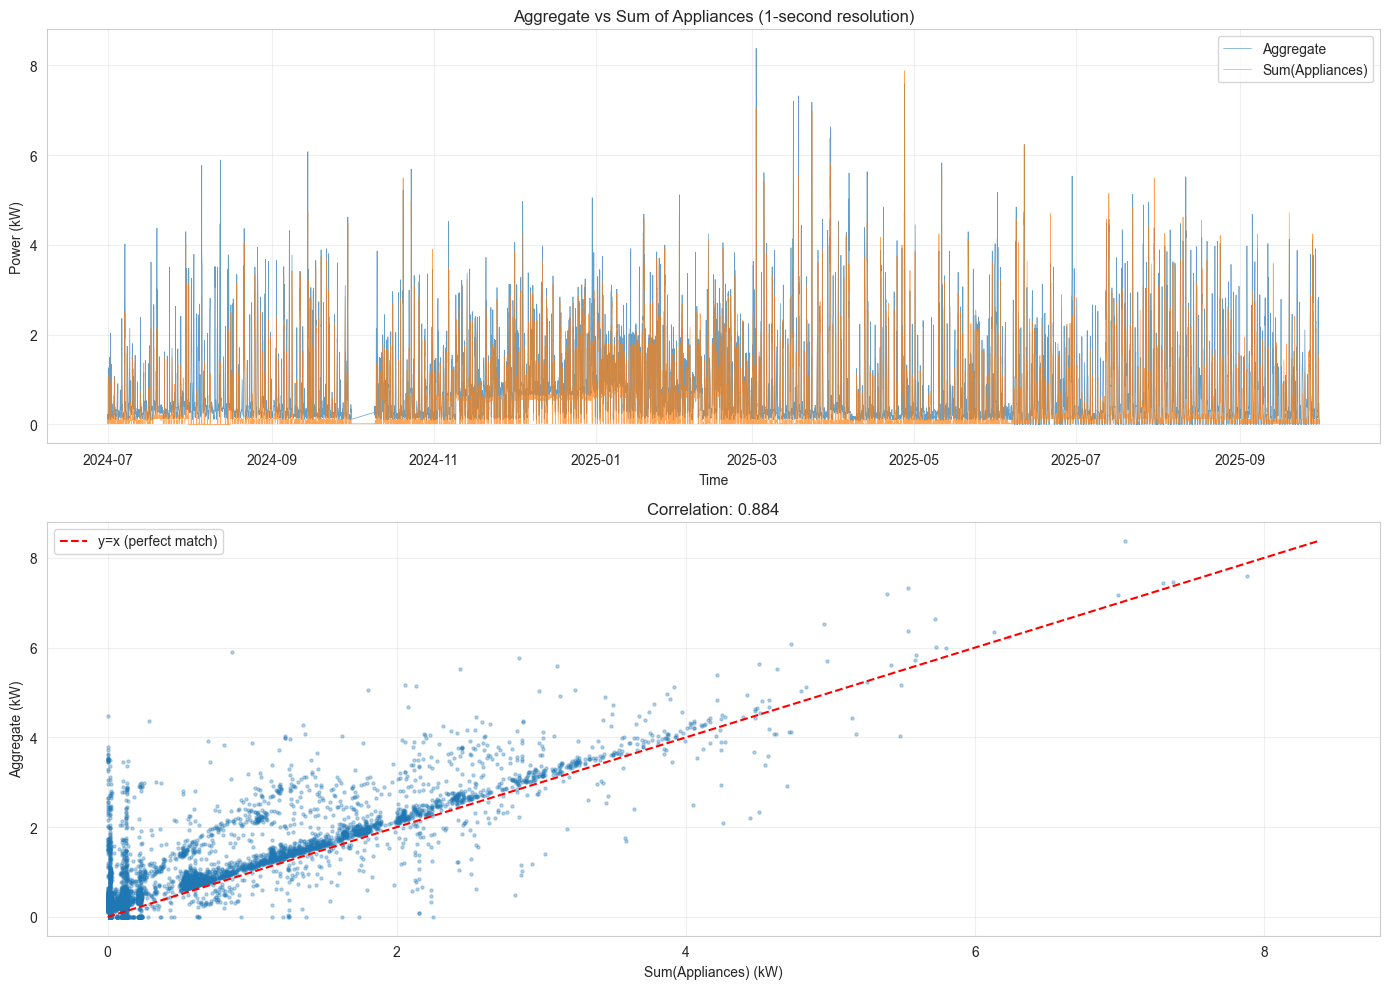

In [9]:
# Sample for visualization (downsampled for plotting efficiency)
sample_size = min(10000, len(df))
df_sample = df.sample(sample_size, random_state=42).sort_values('Time')

# Recalculate sum for visualization
appliance_cols = ['HeatPump', 'Dishwasher', 'WashingMachine', 'Dryer', 'Oven', 
                  'Stove', 'RangeHood', 'EVCharger', 'EVSocket', 'GarageCabinet', 'RainwaterPump']
existing_appliances = [c for c in appliance_cols if c in df_sample.columns]
df_sample['_sum'] = df_sample[existing_appliances].sum(axis=1)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Time series: Aggregate vs Sum
ax1 = axes[0]
ax1.plot(df_sample['Time'], df_sample['Aggregate'], alpha=0.7, label='Aggregate', linewidth=0.5)
ax1.plot(df_sample['Time'], df_sample['_sum'], alpha=0.7, label='Sum(Appliances)', linewidth=0.5)
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (kW)')
ax1.set_title('Aggregate vs Sum of Appliances (1-second resolution)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Scatter: Aggregate vs Sum
ax2 = axes[1]
ax2.scatter(df_sample['_sum'], df_sample['Aggregate'], alpha=0.3, s=5)
max_val = max(df_sample['Aggregate'].max(), df_sample['_sum'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', label='y=x (perfect match)')
ax2.set_xlabel('Sum(Appliances) (kW)')
ax2.set_ylabel('Aggregate (kW)')
corr = df_sample['Aggregate'].corr(df_sample['_sum'])
ax2.set_title(f'Correlation: {corr:.3f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 7. Null Handling

Interpolation for small gaps (≤60 seconds) via forward/backward fill.
Larger gaps are dropped to maintain temporal continuity.

In [10]:
print('='*70)
print('🔧 NULL HANDLING')
print('='*70)

# Check for nulls
null_counts = df.isna().sum()
total_nulls = null_counts.sum()

print(f'\nNull values before handling: {total_nulls}')

if total_nulls > 0:
    for col in df.columns:
        if null_counts[col] > 0:
            print(f'   {col}: {null_counts[col]:,}')
    
    # Forward fill for small gaps (up to 60 rows at 1sec = 1 minute)
    df = df.fillna(method='ffill', limit=60)
    df = df.fillna(method='bfill', limit=60)
    
    # Drop remaining
    remaining_nulls = df.isna().sum().sum()
    if remaining_nulls > 0:
        print(f'\n   Remaining nulls after interpolation: {remaining_nulls}')
        df = df.dropna()
        print(f'   After dropping: {len(df):,} rows')
    else:
        print(f'\n   ✅ All nulls filled')
else:
    print('   ✅ No null values!')

print(f'\nDataset after null handling: {len(df):,} rows')

🔧 NULL HANDLING

Null values before handling: 4016133
   EVCharger: 1,338,711
   EVSocket: 1,338,711
   GarageCabinet: 1,338,711

   Remaining nulls after interpolation: 4015773
   After dropping: 37,364,405 rows

Dataset after null handling: 37,364,405 rows


---
## 8. Export Parquet

Save processed dataset in Parquet format (efficient for ~38M rows).

**Column structure**:
- `Time` — Timestamp
- `Aggregate` + 11 appliances — Consumption in kW
- 6 temporal features — Cyclical encoding

**Note**: Solar, Grid, Battery are **NOT** included (consistent with 15min pipeline).

In [11]:
print('='*70)
print('💾 EXPORTING DATASET (1-SECOND RESOLUTION)')
print('='*70)

# Reorder columns for consistency
temporal_cols = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']

# Define column order (NILM: Time + Aggregate + Appliances + Temporal)
# NOTE: Solar, Grid, Battery NOT included - they are energy flow, not consumption
# This is consistent with the 15min preprocessing pipeline
appliance_order = ['Aggregate', 'HeatPump', 'Dishwasher', 'WashingMachine', 'Dryer', 
                   'Oven', 'Stove', 'RangeHood', 'EVCharger', 'EVSocket', 
                   'GarageCabinet', 'RainwaterPump']

# Filter to existing columns
appliance_order = [c for c in appliance_order if c in df.columns]

final_cols = ['Time'] + appliance_order + temporal_cols
df = df[final_cols]

print(f'\nFinal dataset:')
print(f'   Rows: {len(df):,}')
print(f'   Columns: {len(df.columns)}')
print(f'   Resolution: 1 SECOND (native, no resampling)')
print(f'   Time range: {df["Time"].min()} → {df["Time"].max()}')
print(f'   Columns: {list(df.columns)}')

# Export - using parquet for efficiency with large dataset
parquet_path = OUTPUT_DIR / 'nilm_ready_1sec_new.parquet'
df.to_parquet(parquet_path, index=False)

print(f'\n✅ Exported:')
print(f'   Parquet: {parquet_path}')
print(f'   Size: {parquet_path.stat().st_size / 1e9:.2f} GB')

# Also save metadata
metadata = {
    'rows': len(df),
    'columns': list(df.columns),
    'time_start': str(df['Time'].min()),
    'time_end': str(df['Time'].max()),
    'resolution': '1 second (native)',
    'source': '1sec_new (filtered to TRUE 1-second periods only)',
    'excluded_periods': [
        {'period': 'A', 'start': '2024-04-15', 'end': '2024-05-31', 'reason': '10-second resolution, not 1-second'}
    ],
    'usable_periods': [
        {'period': 'B', 'start': '2024-07-01', 'end': '2024-09-30', 'days': 92, 'resolution': '1 second'},
        {'period': 'C', 'start': '2024-10-09', 'end': '2025-09-30', 'days': 356, 'resolution': '1 second'}
    ],
    'preprocessing_notes': [
        'Applied clip(lower=0) for all appliances (sensor offset removal)',
        'Fixed double counting: garage_cabinet -= ev_charger + ev_socket',
        'Applied noise thresholding: values < 5W → 0',
        'Kept negative values for solar, grid (bidirectional energy flow)',
        'EXCLUDED April-May 2024 (Period A) - data was 10-second, not 1-second!',
        'Solar, Grid, Battery NOT included (energy flow, not consumption - consistent with 15min)',
        'Added cyclical temporal features (hour, dow, month sin/cos)',
        'Filtered to 2 continuous gap-free periods (~448 days total)'
    ],
    'noise_threshold_kw': 0.005
}

import json
with open(OUTPUT_DIR / 'dataset_metadata_1sec_new.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f'   Metadata: {OUTPUT_DIR / "dataset_metadata_1sec_new.json"}')

💾 EXPORTING DATASET (1-SECOND RESOLUTION)

Final dataset:
   Rows: 37,364,405
   Columns: 19
   Resolution: 1 SECOND (native, no resampling)
   Time range: 2024-07-01 00:00:00+00:00 → 2025-09-30 23:59:59+00:00
   Columns: ['Time', 'Aggregate', 'HeatPump', 'Dishwasher', 'WashingMachine', 'Dryer', 'Oven', 'Stove', 'RangeHood', 'EVCharger', 'EVSocket', 'GarageCabinet', 'RainwaterPump', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']

✅ Exported:
   Parquet: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\1sec_new\nilm_ready_1sec_new.parquet
   Size: 0.54 GB
   Metadata: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\1sec_new\dataset_metadata_1sec_new.json


---
## 9. Train/Val/Test Split

**Method**: Block-interleaved (not chronological)

7-day blocks assigned with pattern `[Train, Train, Train, Train, Val, Test]`.
This ensures seasonal coverage across all sets, not just recent data in test.

| Set | Proportion | Purpose |
|-----|------------|---------|
| Train | ~67% | Model training |
| Val | ~17% | Hyperparameter tuning |
| Test | ~17% | Final evaluation |

In [13]:
print('='*70)
print('📊 CREATE BLOCK-INTERLEAVED SPLITS (SEASONAL)')
print('='*70)

def block_time_series_split(df, block_days=7, pattern=None, time_column='Time'):
    """Split time-series data in block-interleaved fashion (Train/Val/Test).
    
    This ensures seasonal coverage across all sets, not just chronological.
    Pattern [0,0,0,0,1,2] with 7-day blocks means:
        - 4 weeks → Train
        - 1 week → Validation  
        - 1 week → Test
    Then repeats. Gives ~67% train, ~17% val, ~17% test.
    """
    if pattern is None:
        pattern = [0, 0, 0, 0, 1, 2]  # 0=Train, 1=Val, 2=Test
    
    df = df.copy()
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(time_column).reset_index(drop=True)
    
    samples_per_day = 24 * 3600  # 1-second resolution
    block_size = block_days * samples_per_day
    
    df['_block'] = df.index // block_size
    df['_set'] = df['_block'].apply(lambda x: pattern[x % len(pattern)])
    
    train_df = df[df['_set'] == 0].drop(columns=['_block', '_set'])
    val_df = df[df['_set'] == 1].drop(columns=['_block', '_set'])
    test_df = df[df['_set'] == 2].drop(columns=['_block', '_set'])
    
    return train_df, val_df, test_df

# Execute split
train_df, val_df, test_df = block_time_series_split(df)
splits = {'train': train_df, 'val': val_df, 'test': test_df}

# Save splits as CSV
SPLIT_DIR = OUTPUT_DIR / 'splits'
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

print(f'\nBlock-interleaved split (7-day blocks, pattern [0,0,0,0,1,2]):')
for split_name, split_df in splits.items():
    csv_path = SPLIT_DIR / f'{split_name}.csv'
    split_df.to_csv(csv_path, index=False)
    pct = len(split_df) / len(df) * 100
    print(f'   ✅ {split_name:8} → {csv_path.name:15} ({len(split_df):>12,} rows, {pct:5.1f}%)')

📊 CREATE BLOCK-INTERLEAVED SPLITS (SEASONAL)

Block-interleaved split (7-day blocks, pattern [0,0,0,0,1,2]):
   ✅ train    → train.csv       (  25,268,405 rows,  67.6%)
   ✅ val      → val.csv         (   6,048,000 rows,  16.2%)
   ✅ test     → test.csv        (   6,048,000 rows,  16.2%)


---
## 10. Summary Statistics

Descriptive statistics of the final dataset to validate value ranges.

In [ ]:
# Final summary statistics
print('='*70)
print('📊 FINAL SUMMARY')
print('='*70)
print()
print(df.describe().round(4).to_string())

📊 FINAL SUMMARY

          Aggregate      HeatPump    Dishwasher  WashingMachine         Dryer          Oven         Stove     RangeHood     EVCharger      EVSocket  GarageCabinet  RainwaterPump      hour_sin      hour_cos       dow_sin       dow_cos     month_sin     month_cos
count  3.736440e+07  3.736440e+07  3.736440e+07    3.736440e+07  3.736440e+07  3.736440e+07  3.736440e+07  3.736440e+07  3.736440e+07  3.736440e+07   3.736440e+07   3.736440e+07  3.736440e+07  3.736440e+07  3.736440e+07  3.736440e+07  3.736440e+07  3.736440e+07
mean   7.740000e-01  1.866000e-01  1.890000e-02    2.330000e-02  7.000000e-04  1.070000e-02  6.900000e-03  6.000000e-04  1.417000e-01  7.580000e-02   2.574000e-01   1.000000e-04 -1.400000e-03  2.000000e-04 -1.400000e-03  5.600000e-03 -6.110000e-02 -1.413000e-01
std    9.742000e-01  3.988000e-01  1.146000e-01    1.333000e-01  2.960000e-02  1.032000e-01  8.780000e-02  4.700000e-03  6.136000e-01  3.443000e-01   4.284000e-01   7.800000e-03  7.071000e-01  7.07

---
## 📁 Generated Files

Verify output structure in `data/processed/1sec_new/`.

In [ ]:
# List all output files
print('='*70)
print('📁 OUTPUT FILES')
print('='*70)

for root, dirs, files in os.walk(OUTPUT_DIR):
    level = root.replace(str(OUTPUT_DIR), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for f in files:
        full_path = Path(root) / f
        size_mb = full_path.stat().st_size / 1e6
        print(f'{subindent}{f} ({size_mb:.1f} MB)')

📁 OUTPUT FILES
1sec_new/
  dataset_metadata_1sec_new.json (0.0 MB)
  nilm_ready_1sec_new.parquet (540.8 MB)
  model_ready/
    scaler.pkl (0.0 MB)
    X_test.npy (435.4 MB)
    X_train.npy (1819.3 MB)
    X_val.npy (435.4 MB)
    y_test.npy (532.2 MB)
    y_train.npy (2223.6 MB)
    y_val.npy (532.2 MB)
  splits/
    test.csv (1172.6 MB)
    train.csv (4842.0 MB)
    val.csv (1179.8 MB)


In [ ]:
# Summary of outputs (coherent with 15min pipeline)
print('\n' + '='*70)
print('✅ DATA PREPARATION COMPLETE')
print('='*70)

print(f'''
Output Directory: {OUTPUT_DIR}

Files Created:
├── nilm_ready_1sec_new.parquet  — Full processed dataset
├── dataset_metadata_1sec_new.json  — Metadata and preprocessing notes
└── splits/
    ├── train.csv  — Training set (~67%)
    ├── val.csv    — Validation set (~17%)
    └── test.csv   — Test set (~17%)

Dataset Info:
   Resolution: 1 SECOND (native)
   Periods: B (Jul-Sep 2024) + C (Oct 2024 - Sep 2025)
   Excluded: Period A (Apr-May 2024) - was 10-second resolution!
   Total: ~{len(df):,} rows, {(df['Time'].max() - df['Time'].min()).days} days

Ready for: nilm_pretraining_1sec_new.ipynb
''')


✅ DATA PREPARATION COMPLETE

Output Directory: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\1sec_new

Files Created:
├── nilm_ready_1sec_new.parquet  — Full processed dataset
├── dataset_metadata_1sec_new.json  — Metadata and preprocessing notes
└── splits/
    ├── train.csv  — Training set (~67%)
    ├── val.csv    — Validation set (~17%)
    └── test.csv   — Test set (~17%)

Dataset Info:
   Resolution: 1 SECOND (native)
   Periods: B (Jul-Sep 2024) + C (Oct 2024 - Sep 2025)
   Excluded: Period A (Apr-May 2024) - was 10-second resolution!
   Total: ~37,364,405 rows, 456 days

Ready for: nilm_pretraining_1sec_new.ipynb



---
## ✅ Pipeline Complete

| Output | Description |
|--------|-------------|
| `nilm_ready_1sec_new.parquet` | Complete dataset (1-second) |
| `dataset_metadata_1sec_new.json` | Preprocessing metadata |
| `splits/train.csv` | Training set (~67%) |
| `splits/val.csv` | Validation set (~17%) |
| `splits/test.csv` | Test set (~17%) |

### Dataset Characteristics
- **Resolution**: 1 second (native)
- **Periods**: July 2024 - September 2025 (~448 days)
- **Split**: Block-interleaved for seasonal coverage
- **Structure**: Coherent with 15min pipeline

**Next step**: `nilm_pretraining_1sec_new.ipynb` to create model-ready numpy arrays.